# Optimization Project 2

<br />

## Team Members


| Name | EID |
| --- | --- |
| Emily McCullough | emm3863 |
| Lydia Wang | lw28423 |
| Ramya Desineedi | rd32895 |
| Yashpreet Kaur | yk8742 |

In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action = 'ignore')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data Prepocessing

**Prepare the daily return table**

In [2]:
df = pd.read_csv('stocks2019.csv')
df2 = pd.read_csv('stocks2020.csv')

df_ret = df.iloc[:,1:] / df.iloc[:,1:].shift(1) - 1 
df_ret['date'] = df.iloc[:,0] #add back the date to the daily return table
df_ret['date'] = pd.to_datetime(df_ret['date'].apply(str), format='%Y-%m-%d')
df_ret.set_index(df_ret.pop('date'), inplace=True)
df_ret = df_ret.iloc[1:,1:] #remove the first row to avoid nans, 
                            #remove the NDX to calculate correlation between stocks

df_ret2 = df2.iloc[:,1:] / df2.iloc[:,1:].shift(1) - 1 
df_ret2['date'] = df2.iloc[:,0] #add back the date to the daily return table
df_ret2['date'] = pd.to_datetime(df_ret2['date'].apply(str), format='%m/%d/%y')
df_ret2.set_index(df_ret2.pop('date'), inplace=True)
df_ret2 = df_ret2.iloc[1:,1:] #remove the first row to avoid nans, 
                              #remove the NDX to calculate correlation between stocks
    
df_ret.head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.03551,-0.03950,-0.09453,0.02203,-0.08579,-0.02770,-0.02848,-0.02524,-0.01522,-0.06040,...,-0.02283,-0.01859,-0.03499,-0.03056,-0.00213,-0.01044,-0.03581,-0.06822,-0.00394,-0.03765
2019-01-04,0.03990,0.04863,0.11437,0.05778,0.01044,0.05129,0.05379,0.05006,0.03418,0.02428,...,0.05898,0.04795,0.04474,0.04415,0.05479,0.03327,0.06058,0.04236,0.00979,0.04630
2019-01-07,0.02820,0.01357,0.08263,0.01830,0.01719,-0.00199,-0.00217,0.03435,0.01346,0.00629,...,0.02207,0.06262,0.01631,0.00100,0.01824,0.00575,0.00092,0.03552,-0.00433,0.02642
2019-01-08,0.03031,0.01492,0.00875,0.00621,0.01595,0.00878,0.00738,0.01661,0.01282,0.02440,...,0.01028,0.01845,0.03646,0.00890,0.01331,0.02001,0.02110,-0.00962,0.01160,-0.01905
2019-01-09,0.01721,0.01182,-0.02699,0.01243,0.03820,-0.00343,-0.00151,0.00171,-0.00120,0.02534,...,0.02374,0.01880,-0.00816,0.00378,0.02307,0.01205,-0.00461,0.04408,-0.00798,0.00897


**Construct the correlation matrix**

In [3]:
df_ret.corr().head()

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.00000,0.39994,0.36538,0.22316,0.21628,0.43310,0.42678,0.46708,0.20396,0.32935,...,0.32291,0.12824,0.46485,0.31655,0.25968,0.21815,0.31166,0.30308,0.04339,0.24967
ADBE,0.39994,1.00000,0.45285,0.36893,0.36337,0.55212,0.54040,0.59824,0.29198,0.47382,...,0.36039,0.20115,0.71134,0.54124,0.40217,0.22811,0.65043,0.36152,0.20740,0.28950
AMD,0.36538,0.45285,1.00000,0.30183,0.34425,0.41886,0.41725,0.54930,0.15145,0.50373,...,0.33278,0.21062,0.49834,0.33090,0.27298,0.28195,0.40763,0.43889,0.01728,0.47801
ALXN,0.22316,0.36893,0.30183,1.00000,0.33243,0.31599,0.30770,0.36317,0.34202,0.31704,...,0.25714,0.40894,0.35058,0.19149,0.52242,0.19272,0.41640,0.28991,0.04795,0.20036
ALGN,0.21628,0.36337,0.34425,0.33243,1.00000,0.24875,0.25032,0.39928,0.26460,0.32828,...,0.17596,0.12856,0.36089,0.25185,0.33498,0.21959,0.30897,0.28441,0.08806,0.25393


## Linear Programming

**Decision variables are Xij, yj that is 100*100 + 100 = 10,100 decision variables**  
Start with m=5. Find the best 5 stocks to include in your portfolio and the weights of those 5
stocks, using the 2019 data.

### Stock Selection

In [4]:
n = df_ret.shape[1] #number of stocks - 100
m = 5 #number of selected stocks
# n_variables = n*n (Xij)+n Yj

list_1 = list(df_ret.corr().unstack().values)
list_2 = [0]*n
obj_value = list_1 + list_2
obj = np.array(obj_value)
# obj[0,:n*n] = list(df_ret.corr().unstack().values)

obj

array([1.        , 0.39993857, 0.36537639, ..., 0.        , 0.        ,
       0.        ])

In [5]:
#To construct A matrix, we have 100*100 + 100 + 1 constrains and 100*100 + 100 variables
A = np.zeros((n*n + n + 1, n*n + n))

#To better represent the index ij and mapping, we construct an index matrix
I = np.ones((n,n))
for i in range(n):
    I[i] = list(range(n*i, n*(i+1))) 

#For matrix b, its dimension would be (row of A) * 1
b = np.zeros((n*n + n + 1,1))

In [6]:
#First constraint: sum(Yj) from i to n = m
A[0, n*n:] = 1
b[0] = m

#Second constraint: sum(Xij) from j=1 to n for i = 1,..,n equal to 1
for i in range(n):
    b[i+1] = 1
    for j in range(n):
        A[i+1,j + n*i] = 1   #(I[i,][0], I[i,][-1] + 1)

#Third constraint: xij <= yj for i = 1,...,n; for j = 1,...,n
count_i = 0

for i in range(n):
    for j in range(n):
        A[n+1+count_i, int(I[i,j])] = 1
        A[n+1+count_i, n*n + j] = -1
        count_i += 1

sense = np.array(['=']*(n+1) + ['<']*(n*n))

In [7]:
A

array([[ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]])

In [8]:
A.shape

(10101, 10100)

In [9]:
stockModel = gp.Model() # initialize an empty model

stockModX = stockModel.addMVar(n*n+n,vtype=['B']*(n*n+n)) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints

stockModCon = stockModel.addMConstrs(A, stockModX, sense, b) # add the constraints to the model
stockModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

stockModel.Params.OutputFlag = 0 # tell gurobi to shut up!!

stockModel.optimize()

Academic license - for non-commercial use only - expires 2022-10-22
Using license file /Users/lydia/gurobi.lic


In [10]:
stock_result = stockModX.x
stock_result

array([ 0., -0., -0., ..., -0.,  1., -0.])

In [11]:
stockModel.objval

54.83990652229108

In [12]:
x = pd.DataFrame(stock_result[-n:], columns = ['Pick'])
x_index = list(x[x['Pick'] == 1].reset_index()['index'])
x_name = list(df_ret.columns.values[[x_index]])

print(f"The indexes of selected stocks are {x_index}. \
      \nThe tickers of selected stocks are {x_name} \n")

The indexes of selected stocks are [56, 59, 63, 94, 98].       
The tickers of selected stocks are ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'] 



### Calculating Portfolio Weights

**Nasdaq is a market-value-weighted index**

In [13]:
t = len(df_ret)

# extract returns for selected stocks
x_return = df_ret.iloc[:, x_index]
x_return.head()

,LBTYK,MXIM,MSFT,VRTX,XEL
date,,,,,
2019-01-03,-0.00628,-0.05685,-0.03679,-0.00213,-0.00394
2019-01-04,0.06855,0.04400,0.04651,0.05479,0.00979
2019-01-07,-0.04277,0.01039,0.00128,0.01824,-0.00433
2019-01-08,-0.03612,-0.01503,0.00725,0.01331,0.01160
2019-01-09,0.00296,0.02710,0.01430,0.02307,-0.00798


In [14]:
index_name = list(df.columns.values)[1] #extract index name
ndx = df[[index_name]]

ndx_ret = ndx / ndx.shift(1) - 1 
ndx_ret = ndx_ret.iloc[1:,:] 
ndx_ret.head()

,NDX
1,-0.03360
2,0.04482
3,0.01021
4,0.00980
5,0.00745


**We convert the non-linear weights program to a linear one.   
Assume z_i = | q_t - sum of w_i * r_it |   
Then we would minimize z_1 + z_2 + …… + z_T**

In [15]:
#Obj to minimize z_1 + z_2 + …… + z_T, 
#fist m (5) variables are wi, the next t variables are zi, in total there are m+t variables
obj2 = np.array([0]*m + [1]*t)

#To construct A matrix, we have 1 + 2t constrains and m+t variables
A2 = np.zeros((1+2*t, m+t))
b2 = np.zeros((1+2*t,1))
sense2 = np.array(['=']*1 + ['>']*(2*t))

# constraint 1, all weights sum up to 1. 1 row in total 
A2[0, :m] = 1
b2[0] = 1

# constraint 2, each z_i is corresponded to two constraints, convert absolute value 
# 2*t rows in total
A2[1:1+t,m:] = np.diag([1]*t)
A2[1+t:,m:] = np.diag([1]*t)
A2[1:1+t,:m] = x_return
A2[1+t:,:m] = -x_return
b2[1:1+t] = ndx_ret
b2[1+t:] = -ndx_ret

In [16]:
stockModel2 = gp.Model() # initialize an empty model

stockModX2 = stockModel2.addMVar(m+t) # tell the model how many variables there are

stockModCon2 = stockModel2.addMConstrs(A2, stockModX2, sense2, b2) # add the constraints to the model
stockModel2.setMObjective(None,obj2,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0

stockModel2.Params.OutputFlag = 0 # tell gurobi to shut up!!
stockModel2.optimize()

In [17]:
stock_result2 = list(stockModX2.x[:5])
stock_result2

[0.04886174835252491,
 0.21038806005665553,
 0.5803519807862964,
 0.07119021516911037,
 0.08920799563541283]

In [18]:
stockModel2.objval

0.7891782824631473

In [19]:
# print(f"The minimum sum of absolute tracking return difference is {stockModel2.objval}. \
#       \nThe weight for {x_name: x_weight for x_name, x_weight in x_name, stock_result2}")
print(f"The minimum sum of absolute tracking return difference is {stockModel2.objval:.5f}.")
for i in range(m):
    print(f"The weight for {x_name[i]} is {stock_result2[i]:.5f}")

The minimum sum of absolute tracking return difference is 0.78918.
The weight for LBTYK is 0.04886
The weight for MXIM is 0.21039
The weight for MSFT is 0.58035
The weight for VRTX is 0.07119
The weight for XEL is 0.08921


**Performance Evaluation - Using 2020 data**

In [20]:
index_name = list(df2.columns.values)[1] #extract index name
ndx2 = df2[[index_name]]

ndx_ret2 = ndx2 / ndx2.shift(1) - 1 
ndx_ret2 = ndx_ret2.iloc[1:,:] 

x_return2 = df_ret2.iloc[:, x_index]
x_return_weighted_2 = x_return2 * stock_result2
x_return_weighted_2['Index_Return_Predicted'] = x_return_weighted_2.sum(axis=1)
x_return_weighted_2['Index_Return'] = list(ndx_ret2[index_name])
x_return_weighted_2['Abs_Difference'] = abs(x_return_weighted_2['Index_Return'] - \
                                        x_return_weighted_2['Index_Return_Predicted']) 
x_return_weighted_2['Index'] = list(df2[index_name][1:])
x_return_weighted_2['Index_Predicted'] = (x_return_weighted_2['Index_Return_Predicted'] + 1).cumprod() * df2[index_name][0]

x_return_weighted_2.head()

,LBTYK,MXIM,MSFT,VRTX,XEL,Index_Return_Predicted,Index_Return,Abs_Difference,Index,Index_Predicted
date,,,,,,,,,,
2020-01-03,-0.00079,-0.00364,-0.00723,-0.00048,0.00043,-0.01171,-0.00883,0.00288,8793.90039,8768.36516
2020-01-06,0.00074,-0.00381,0.00150,0.00198,-0.00013,0.00028,0.00621,0.00593,8848.51953,8770.79591
2020-01-07,-0.00039,0.00475,-0.00529,-0.00008,-0.00019,-0.00119,-0.00023,0.00095,8846.45019,8760.37251
2020-01-08,-0.00212,-0.00007,0.00924,0.00232,-0.00009,0.00929,0.00745,0.00184,8912.37012,8841.74633
2020-01-09,-0.00119,0.00154,0.00725,-0.00026,0.00020,0.00754,0.00867,0.00113,8989.62988,8908.40109


In [21]:
print(f"The sum of absolute tracking return difference for 2020 is {x_return_weighted_2.sum(axis=0)[7]:.5f}.")

The sum of absolute tracking return difference for 2020 is 1.11244.


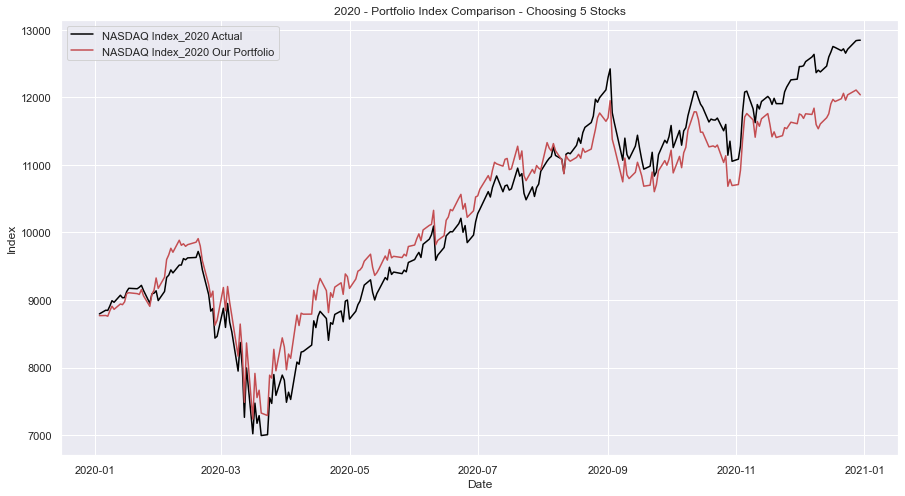

In [22]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,8))

ax.plot(x_return_weighted_2.index.values, x_return_weighted_2['Index'], color = 'black', label = 'NASDAQ Index_2020 Actual')
ax.plot(x_return_weighted_2.index.values, x_return_weighted_2['Index_Predicted'], color = 'r', label = 'NASDAQ Index_2020 Our Portfolio')

ax.legend()
ax.set_title('2020 - Portfolio Index Comparison - Choosing 5 Stocks')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
plt.show()

## Question 3

**Define Function**

In [23]:
def replicate(m):
    n = df_ret.shape[1] #number of stocks
    if m > n:
        m = n #limit m less than n

    list_1 = list(df_ret.corr().unstack().values)
    list_2 = [0]*n
    obj_value = list_1 + list_2
    obj = np.array(obj_value)

    #To construct A matrix, we have 100*100 + 100 + 1 constrains and 100*100 + 100 variables
    A = np.zeros((n*n + n + 1, n*n + n))
    
    #To better represent the index ij and mapping, we construct an index matrix
    I = np.ones((n,n))
    for i in range(n):
        I[i] = list(range(n*i, n*(i+1))) 
   
    #For matrix b, its dimension would be (row of A) * 1
    b = np.zeros((n*n + n + 1,1))
    sense = np.array(['=']*(n+1) + ['<']*(n*n))
    #First constraint: sum(Yj) from i to n = m
    A[0, n*n:] = 1
    b[0] = m
    
    #Second constraint: sum(Xij) from j=1 to n for i = 1,..,n equal to 1
    for i in range(n):
        b[i+1] = 1
        for j in range(n):
            A[i+1,j + n*i] = 1   #(I[i,][0], I[i,][-1] + 1)
    
    #Third constraint: xij <= yj for i = 1,...,n; for j = 1,...,n
    count_i = 0
    
    for i in range(n):
        for j in range(n):
            A[n+1+count_i, int(I[i,j])] = 1
            A[n+1+count_i, n*n + j] = -1
            count_i += 1
    
    sense = np.array(['=']*(n+1) + ['<']*(n*n))

    stockModel = gp.Model() # initialize an empty model
    
    stockModX = stockModel.addMVar(n*n+n,vtype=['B']*(n*n+n)) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    
    stockModCon = stockModel.addMConstrs(A, stockModX, sense, b) # add the constraints to the model
    stockModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0
    
    stockModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockModel.optimize()
    
    stock_result = stockModX.x
    stock_obj = stockModel.objval

    x = pd.DataFrame(stock_result[-n:], columns = ['Pick'])
    x_index = list(x[x['Pick'] == 1].reset_index()['index'])
    x_name = list(df_ret.columns.values[[x_index]])

    x_return = df_ret.iloc[:, x_index]
    x_return.head()
    t = len(df_ret)

    # extract returns for selected stocks
    x_return = df_ret.iloc[:, x_index]
    index_name = list(df.columns.values)[1] #extract index name
    ndx = df[[index_name]]

    ndx_ret = ndx / ndx.shift(1) - 1 
    ndx_ret = ndx_ret.iloc[1:,:] 

    obj2 = np.array([0]*m + [1]*t)
    
    A2 = np.zeros((1+2*t, m+t))
    b2 = np.zeros((1+2*t,1))
    sense2 = np.array(['=']*1 + ['>']*(2*t))
    
    # constraint 1, all weights sum up to 1. 1 row in total 
    A2[0, :m] = 1
    b2[0] = 1
    
    # constraint 2, each z_i is corresponded to two constraints, convert absolute value 
    # 2*t rows in total
    A2[1:1+t,m:] = np.diag([1]*t)
    A2[1+t:,m:] = np.diag([1]*t)
    A2[1:1+t,:m] = x_return
    A2[1+t:,:m] = -x_return
    b2[1:1+t] = ndx_ret
    b2[1+t:] = -ndx_ret
    
    stockModel2 = gp.Model() # initialize an empty model
    
    stockModX2 = stockModel2.addMVar(m+t) # tell the model how many variables there are
    
    stockModCon2 = stockModel2.addMConstrs(A2, stockModX2, sense2, b2) # add the constraints to the model
    stockModel2.setMObjective(None,obj2,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0
    
    stockModel2.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockModel2.optimize()
    stock_result2 = list(stockModX2.x[:m])
    stock_obj2 = stockModel2.objval

    ndx2 = df2[[index_name]]

    ndx_ret2 = ndx2 / ndx2.shift(1) - 1 
    ndx_ret2 = ndx_ret2.iloc[1:,:] 

    x_return2 = df_ret2.iloc[:, x_index]
    x_return_weighted_2 = x_return2 * stock_result2
    x_return_weighted_2['Index_Return_Predicted'] = x_return_weighted_2.sum(axis=1)
    x_return_weighted_2['Index_Return'] = list(ndx_ret2[index_name])
    x_return_weighted_2['Abs_Difference'] = abs(x_return_weighted_2['Index_Return'] - \
                                            x_return_weighted_2['Index_Return_Predicted']) 
    x_return_weighted_2['Index'] = list(df2[index_name][1:])
    x_return_weighted_2['Index_Predicted'] = (x_return_weighted_2['Index_Return_Predicted'] + 1).cumprod() * df2[index_name][0]

    return [m, stockModel2.objval, x_return_weighted_2.sum(axis=0)[m+2]]
#     return stock_result2

In [24]:
m_list = [5] + list(range(10,110,10))
replicate_table = pd.DataFrame(columns = ['Number of Stocks','2019_Tracking difference','2020_Tracking difference'])

for m in m_list:
    replicate_table.loc[len(replicate_table.index)]= replicate(m)
    
replicate_table['Number of Stocks'] = replicate_table['Number of Stocks'].astype(int)
replicate_table

,Number of Stocks,2019_Tracking difference,2020_Tracking difference
0,5,0.78918,1.11244
1,10,0.68653,1.09771
2,20,0.47884,0.89960
3,30,0.41801,0.76911
4,40,0.36744,0.78833
5,50,0.33401,0.77322
6,60,0.34379,1.16644
7,70,0.16859,0.54574
8,80,0.14768,0.53732
9,90,0.05378,0.36779


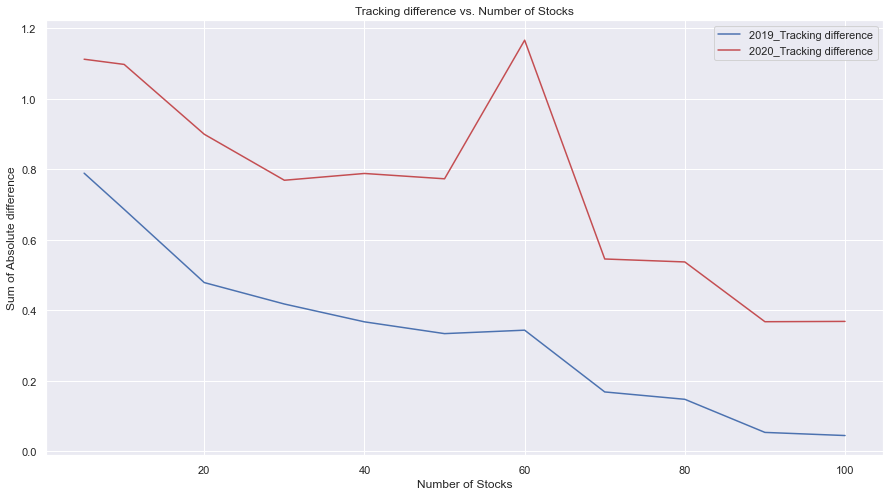

In [25]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,8))

ax.plot(replicate_table['Number of Stocks'], replicate_table['2019_Tracking difference'], color = 'b', label = '2019_Tracking difference')
ax.plot(replicate_table['Number of Stocks'], replicate_table['2020_Tracking difference'], color = 'r', label = '2020_Tracking difference')

ax.legend()
ax.set_title('Tracking difference vs. Number of Stocks')
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('Sum of Absolute difference')
plt.show()

## Question 4

In [26]:
obj3 = np.array([0]*n + [1]*t + [0]*n) #wi, Zi, yi (newly added)
obj3.shape

(450,)

In [27]:
timelimit = 3600 #set time limit - 1hr = 3600s

def replicate_combine(m):
    n = df_ret.shape[1] #number of stocks
    t = len(df_ret)
    
    # extract returns for selected stocks
    x_return = df_ret
    index_name = list(df.columns.values)[1] #extract index name
    ndx = df[[index_name]]

    ndx_ret = ndx / ndx.shift(1) - 1 
    ndx_ret = ndx_ret.iloc[1:,:] 

    obj3 = np.array([0]*n + [1]*t + [0]*n) #wi, Zi, yi (newly added)
    
    A3 = np.zeros((1+2*t+n+1, 2*n+t)) 
    b3 = np.zeros((1+2*t+n+1,1))
    sense3 = np.array(['=']*1 + ['>']*(2*t) + ['<']*(n) + ['='] )
    
    # constraint 1, all weights sum up to 1. 1 row in total 
    A3[0, :n] = 1
    b3[0] = 1
    
    # constraint 2, each z_i is corresponded to two constraints, convert absolute value 
    # 2*t rows in total
    A3[1:1+t,n:n+t] = np.diag([1]*t)
    A3[1+t:1+2*t,n:n+t] = np.diag([1]*t)
    A3[1:1+t,:n] = x_return
    A3[1+t:1+2*t,:n] = -x_return
    b3[1:1+t] = ndx_ret
    b3[1+t: 1+2*t] = -ndx_ret
    
    #constraint 3: wi <= yi for i = 1,...,n; Big M can be 1 in our case
    A3[1+2*t:1+2*t+n,:n] = np.diag([1]*n)
    A3[1+2*t:1+2*t+n,n+t:] = np.diag([-1]*n)

    #constraint 4: sum of y’s is equal to m
    A3[1+2*t+n,n+t:] = 1
    b3[-1] = m
    
    stockModel3 = gp.Model() # initialize an empty model
    stockModel3.Params.OutputFlag = 0 # tell gurobi to shut up!!
    stockModel3.Params.timeLimit = timelimit #set time limit - 1hr = 3600s
    
    stockModX3 = stockModel3.addMVar(2*n+t, vtype=['C']*(n+t) + ['B']*n) # tell the model how many variables there are
    
    stockModCon3 = stockModel3.addMConstrs(A3, stockModX3, sense3, b3) # add the constraints to the model
    stockModel3.setMObjective(None,obj3,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0
    
    stockModel3.optimize()
    stock_result3 = list(stockModX3.x[:n])
    stock_obj3 = stockModel3.objval

    x_return2 = df_ret2
    x_return_weighted_3 = x_return2 * stock_result3
    x_return_weighted_3['Index_Return_Predicted'] = x_return_weighted_3.sum(axis=1)
    x_return_weighted_3['Index_Return'] = list(ndx_ret2[index_name])
    x_return_weighted_3['Abs_Difference'] = abs(x_return_weighted_3['Index_Return'] - \
                                            x_return_weighted_3['Index_Return_Predicted']) 
    x_return_weighted_3['Index'] = list(df2[index_name][1:])
    x_return_weighted_3['Index_Predicted'] = (x_return_weighted_3['Index_Return_Predicted'] + 1).cumprod() * df2[index_name][0]

    return [m, stockModel3.objval, x_return_weighted_3.sum(axis=0)[n+2]]
#     return stock_result3

In [28]:
m_list = [5] + list(range(10,110,10))
replicate_table = pd.DataFrame(columns = ['Number of Stocks','2019_Tracking difference','2020_Tracking difference'])

for m in m_list:
    replicate_table.loc[len(replicate_table.index)]= replicate_combine(m)
    
replicate_table['Number of Stocks'] = replicate_table['Number of Stocks'].astype(int)
replicate_table

,Number of Stocks,2019_Tracking difference,2020_Tracking difference
0,5,0.49926,0.77736
1,10,0.29014,0.75337
2,20,0.16131,0.61451
3,30,0.11183,0.50560
4,40,0.08197,0.43210
5,50,0.06231,0.38219
6,60,0.05265,0.37968
7,70,0.04755,0.37181
8,80,0.04523,0.37061
9,90,0.04491,0.36867


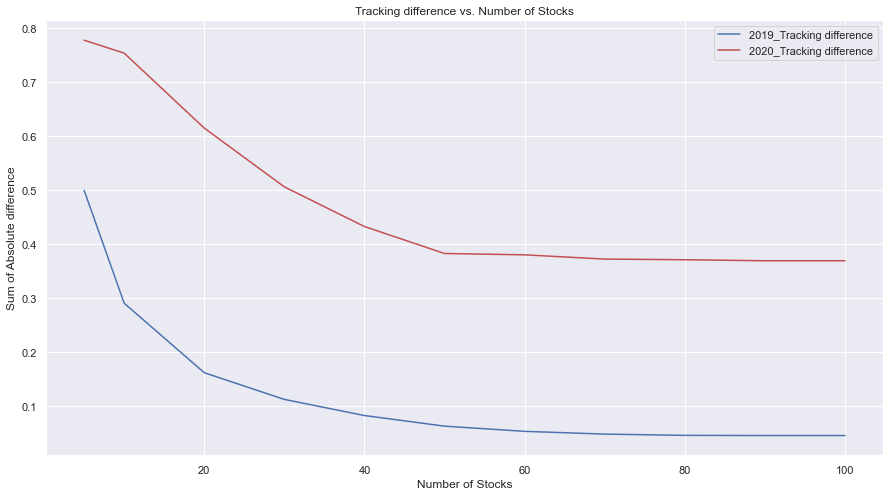

In [29]:
fig, (ax) = plt.subplots(nrows = 1, ncols = 1, figsize = (15,8))

ax.plot(replicate_table['Number of Stocks'], replicate_table['2019_Tracking difference'], color = 'b', label = '2019_Tracking difference')
ax.plot(replicate_table['Number of Stocks'], replicate_table['2020_Tracking difference'], color = 'r', label = '2020_Tracking difference')

ax.legend()
ax.set_title('Tracking difference vs. Number of Stocks')
ax.set_xlabel('Number of Stocks')
ax.set_ylabel('Sum of Absolute difference')
plt.show()

<hr>

## Archive